# Kaggle
## Competição DSA de Machine Learning - Dezembro 2019

Versão 1.0.0: LB = 0.50557
- modelo: XGBoost (com algumas otimizações)
- features categoricas: removido
- dados missing: atribuído o valor medio

Versão 1.0.1: LB = 0.48972 / CV = 0.469777
- modelo: XGBoost executando todas as otimizações
- features engineering: gerado através do Auto_ViML

Versão 1.0.2: LB = 0.55264 / CV = 0.469158
- modelo: XGBoost executando todas as otimizações
- dados missing: removido colunas com mais de 40% de NA e as demais -999
- features categoricas: label encoder
- feature engineering: usando pacote Boruta

## 1. Importando as bibliotecas

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import gc

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

# Importa pacotes do sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler


## 2. Carregando os dados de treino e teste

In [3]:
def read_data():
    
    if TRAIN_OFFLINE:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('../dataset/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_teste.csv....')
        test = pd.read_csv('../dataset/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
        
    else:
        print('Carregando arquivo dataset_treino.csv....')
        train = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_treino.csv')
        print('dataset_treino.csv tem {} linhas and {} colunas'.format(train.shape[0], train.shape[1]))
        
        print('Carregando arquivo dataset_treino.csv....')
        test = pd.read_csv('/kaggle/input/competicao-dsa-machine-learning-dec-2019/dataset_teste.csv')
        print('dataset_teste.csv tem {} linhas and {} colunas'.format(test.shape[0], test.shape[1]))
    
    return train, test

In [4]:
# Leitura dos dados
train, test = read_data()

Carregando arquivo dataset_treino.csv....
dataset_treino.csv tem 114321 linhas and 133 colunas
Carregando arquivo dataset_teste.csv....
dataset_teste.csv tem 114393 linhas and 132 colunas


## 3. Feature Engineering

In [5]:
# Removendo todas as colunas com mais de 40% de dados missing
train = train[train.columns[train.isnull().mean() <= 0.4]]
test  = test[test.columns[test.isnull().mean() <= 0.4]]
train.shape, test.shape

((114321, 31), (114393, 30))

In [6]:
# Label encoder nas features categoricas
for c in train.columns[train.dtypes == 'object']:
    train[c] = train[c].factorize()[0]
    
for c in test.columns[test.dtypes == 'object']:
    test[c] = test[c].factorize()[0]

In [7]:
# Preenche os dados missing com -999
train.fillna(-999,inplace=True)
test.fillna(-999,inplace=True)

## 4. Feature Selection

In [10]:
from boruta import BorutaPy

# Separando features preditoras e target
X = train.drop(['ID', 'target'], axis=1)
y = train['target']

X = X.values
y = y.values
y = y.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
rf.fit(X, y)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	29
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	22
Tentative: 	1
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	23
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	23
Tentative: 	0
Rejected: 	6


In [12]:
X_filtered.shape

(114321, 23)

## 4. Criar e avaliar alguns algoritmos de Machine Learning

In [13]:
# Separando features preditoras e target
train_x = X_filtered.copy()
train_y = train['target']

# Padronizando os dados
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)

train_x.shape, train_y.shape

## 4.1. Algoritmo XGBoost - Extreme Gradient Boosting

Vamos dar uma olhada nas vantagens desse algoritmo:

***Regularização:***
- O XGBoost também é conhecido como uma técnica de "reforço regularizado", ajudando a reduzir o overfitting

***Processamento paralelo:***
- O XGBoost implementa o processamento paralelo e é incrivelmente mais rápido em comparação com o GBM. Mas, espere, sabemos que impulsionar é um processo seqüencial; portanto, como ele pode ser paralelo? Sabemos que cada árvore pode ser construída somente após a anterior, então o que nos impede de fazer uma árvore usando todos os núcleos?

***Alta flexibilidade***
- O XGBoost permite que os usuários definam objetivos de otimização personalizados e critérios de avaliação. Isso adiciona uma nova dimensão ao modelo e não há limite para o que podemos fazer.

***Tratamento de valores ausentes***
- O XGBoost possui uma rotina integrada para lidar com os valores ausentes. É necessário que o usuário forneça um valor diferente de outras observações e passe isso como um parâmetro. O XGBoost tenta coisas diferentes ao encontrar um valor ausente em cada nó e descobre qual caminho seguir para valores ausentes no futuro.

***Poda de árvores:***
- O XGBoost faz divisões até a profundidade máxima especificada e, em seguida, começa a podar a árvore para trás e remove as divisões além das quais não há ganho positivo.

***Validação cruzada incorporada***
- O XGBoost permite que o usuário execute uma validação cruzada a cada iteração do processo de otimização e, portanto, é fácil obter o número ideal exato de iterações de otimização em uma única execução.

- Você pode começar a treinar um modelo XGBoost a partir da última iteração da execução anterior. Isso pode ser uma vantagem significativa em certas aplicações específicas.

In [14]:
# Criando uma funcao para criação, execução e validação do modelo
def run_model(modelo, X_tr, y_tr, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    # Utilização do Cross-Validation
    if useTrainCV:
        xgb_param = modelo.get_xgb_params()
        xgtrain = xgb.DMatrix(X_tr, label=y_tr)
        
        print ('Start cross validation')
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=modelo.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics=['logloss'],
                          stratified=True,
                          seed=42,
                          verbose_eval=True,
                          early_stopping_rounds=early_stopping_rounds)

        modelo.set_params(n_estimators=cvresult.shape[0])
        best_tree = cvresult.shape[0]
        print('Best number of trees = {}'.format(best_tree-1))
    
    # Fit do modelo
    modelo.fit(X_tr, y_tr, eval_metric='logloss')
        
    # Predição no dataset de treino
    train_pred = modelo.predict(X_tr)
    train_pred_prob = modelo.predict_proba(X_tr)[:,1]
    
    # Exibir o relatorio do modelo
    print("Log Loss (Treino): %f" % log_loss(y_tr, train_pred_prob))
    print("Log Loss (Test): %f" % cvresult['test-logloss-mean'][best_tree-1])
    
    feature_imp = pd.Series(modelo.feature_importances_.astype(float)).sort_values(ascending=False)
    
    plt.figure(figsize=(18,8))
    feature_imp[:25].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.tight_layout()

#### Passo 01: criando o modelo fixando alguns hyperparametros

Start cross validation
[0]	train-logloss:0.661002+0.000135979	test-logloss:0.661123+0.000173076
[1]	train-logloss:0.632391+0.00156897	test-logloss:0.632634+0.00162518
[2]	train-logloss:0.608917+0.00172538	test-logloss:0.609366+0.00168144
[3]	train-logloss:0.588736+0.00142921	test-logloss:0.589394+0.0014731
[4]	train-logloss:0.571919+0.00153507	test-logloss:0.572706+0.00201527
[5]	train-logloss:0.557748+0.00126224	test-logloss:0.558675+0.00186934
[6]	train-logloss:0.545334+0.00100985	test-logloss:0.546399+0.00170911
[7]	train-logloss:0.534926+0.00114461	test-logloss:0.536075+0.00191559
[8]	train-logloss:0.526431+0.000739838	test-logloss:0.527698+0.00163141
[9]	train-logloss:0.518973+0.000989315	test-logloss:0.520363+0.00201024
[10]	train-logloss:0.512434+0.00106502	test-logloss:0.513908+0.00218762
[11]	train-logloss:0.506708+0.000861963	test-logloss:0.50828+0.00200188
[12]	train-logloss:0.501957+0.000589863	test-logloss:0.503608+0.00183242
[13]	train-logloss:0.497982+0.000320973	test-lo

[113]	train-logloss:0.453781+0.000841683	test-logloss:0.468515+0.00163781
[114]	train-logloss:0.453634+0.000859447	test-logloss:0.468518+0.00162993
[115]	train-logloss:0.4535+0.00087943	test-logloss:0.468503+0.00163467
[116]	train-logloss:0.453366+0.000876348	test-logloss:0.468483+0.00160474
[117]	train-logloss:0.453224+0.000825575	test-logloss:0.468443+0.00162708
[118]	train-logloss:0.453078+0.000830324	test-logloss:0.468424+0.0016275
[119]	train-logloss:0.452973+0.000808186	test-logloss:0.468394+0.00162737
[120]	train-logloss:0.452893+0.000828529	test-logloss:0.468401+0.00161856
[121]	train-logloss:0.452791+0.000813723	test-logloss:0.468379+0.00162883
[122]	train-logloss:0.452619+0.00081384	test-logloss:0.468359+0.00163145
[123]	train-logloss:0.452489+0.000811156	test-logloss:0.468358+0.00161298
[124]	train-logloss:0.452352+0.000794327	test-logloss:0.468338+0.0016422
[125]	train-logloss:0.452221+0.000783732	test-logloss:0.468334+0.00167615
[126]	train-logloss:0.452065+0.000768872	tes

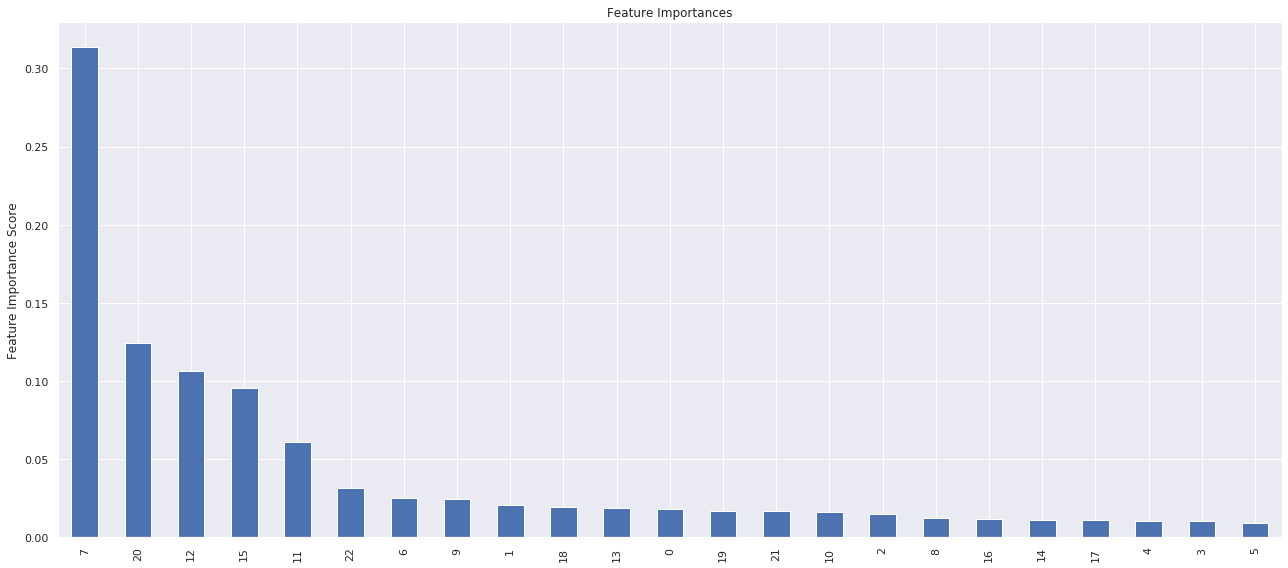

In [15]:
%%time

# Criando o primeiro modelo XGB
modeloXGB = XGBClassifier(learning_rate = 0.1,
                          n_estimators = 1000,
                          max_depth = 5,
                          min_child_weight = 1,
                          gamma = 0,
                          subsample = 0.8,
                          colsample_bytree = 0.8,
                          objective = 'binary:logistic',
                          n_jobs = -1,
                          scale_pos_weight = 1,
                          seed = 42)

run_model(modeloXGB, train_x, train_y)

#### Passo 02: otimização dos parametros: max_depth e min_child_weight

In [16]:
%%time

# Definindo os parametros que serão testados no GridSearch
param_v1 = {
 'max_depth':range(2,5),
 'min_child_weight':range(1,2)
}

grid_1 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, 
                                                n_estimators = 1000, 
                                                max_depth = 5,
                                                min_child_weight = 1, 
                                                gamma = 0, 
                                                subsample = 0.8, 
                                                colsample_bytree = 0.8,
                                                objective = 'binary:logistic', 
                                                nthread = 4,
                                                scale_pos_weight = 1, 
                                                seed = 42),
                      param_grid = param_v1, 
                      scoring = 'neg_log_loss',
                      n_jobs = -1,
                      iid = False, 
                      cv = 5)

# Realizando o fit e obtendo os melhores parametros do grid
grid_1.fit(train_x, train_y)
grid_1.best_params_, grid_1.best_score_

CPU times: user 2min 15s, sys: 1.21 s, total: 2min 17s
Wall time: 4min 57s


({'max_depth': 3, 'min_child_weight': 1}, -0.4704207197012443)

#### Passo 03: otimização dos parametros: gamma

In [17]:
%%time

# Definindo os parametros que serão testados no GridSearch
param_v2 = {
 'gamma':[i/10.0 for i in range(0,2)]
}

grid_2 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, 
                                                n_estimators = 1000, 
                                                max_depth = grid_1.best_params_['max_depth'],
                                                min_child_weight = grid_1.best_params_['min_child_weight'], 
                                                gamma = 0, 
                                                subsample = 0.8, 
                                                colsample_bytree = 0.8,
                                                objective = 'binary:logistic', 
                                                nthread = 4, 
                                                scale_pos_weight = 1, 
                                                seed = 42),
                      param_grid = param_v2, 
                      scoring = 'neg_log_loss',
                      n_jobs = -1,
                      iid = False, 
                      cv = 5)

# Realizando o fit e obtendo os melhores parametros do grid
grid_2.fit(train_x, train_y)
grid_2.best_params_, grid_2.best_score_

CPU times: user 3min 10s, sys: 3.35 s, total: 3min 13s
Wall time: 4min 4s


({'gamma': 0.1}, -0.4702864823795396)

#### Passo 04: otimização dos parametros: subsample e colsample_bytree

In [18]:
%%time

# Definindo os parametros que serão testados no GridSearch
param_v3 = {
 'subsample':[i/10.0 for i in range(6,8)],
 'colsample_bytree':[i/10.0 for i in range(6,8)]
}

grid_3 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, 
                                                n_estimators = 1000, 
                                                max_depth = grid_1.best_params_['max_depth'],
                                                min_child_weight = grid_1.best_params_['min_child_weight'], 
                                                gamma = grid_2.best_params_['gamma'], 
                                                subsample = 0.8, 
                                                colsample_bytree = 0.8,
                                                objective = 'binary:logistic', 
                                                nthread = 4, 
                                                scale_pos_weight = 1, 
                                                seed = 42),
                      param_grid = param_v3, 
                      scoring = 'neg_log_loss',
                      n_jobs = -1,
                      iid = False, 
                      cv = 5)

grid_3.fit(train_x, train_y)
grid_3.best_params_, grid_3.best_score_

CPU times: user 2min 29s, sys: 1.94 s, total: 2min 31s
Wall time: 6min 8s


({'colsample_bytree': 0.6, 'subsample': 0.7}, -0.4709450532104416)

#### Passo 05: otimização dos parametros: reg_alpha

In [19]:
%%time

# Definindo os parametros que serão testados no GridSearch
param_v4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

grid_4 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, 
                                                n_estimators = 1000, 
                                                max_depth = grid_1.best_params_['max_depth'],
                                                min_child_weight = grid_1.best_params_['min_child_weight'], 
                                                gamma = grid_2.best_params_['gamma'], 
                                                subsample = grid_3.best_params_['subsample'], 
                                                colsample_bytree = grid_3.best_params_['colsample_bytree'],
                                                objective = 'binary:logistic', 
                                                nthread = 4, 
                                                scale_pos_weight = 1, 
                                                seed = 42),
                      param_grid = param_v4, 
                      scoring = 'neg_log_loss',
                      n_jobs = -1,
                      iid = False, 
                      cv = 5)

# Realizando o fit e obtendo os melhores parametros do grid
grid_4.fit(train_x, train_y)
grid_4.best_params_, grid_4.best_score_

CPU times: user 2min 11s, sys: 1.36 s, total: 2min 12s
Wall time: 7min 28s


({'reg_alpha': 0.001}, -0.4708285764096753)

## Passo 06: reduzindo Learning Rate

Start cross validation
[0]	train-logloss:0.683876+1.91729e-05	test-logloss:0.683884+2.42107e-05
[1]	train-logloss:0.674393+0.000334378	test-logloss:0.674417+0.000310565
[2]	train-logloss:0.665873+0.000553829	test-logloss:0.665883+0.000563487
[3]	train-logloss:0.657861+0.000690907	test-logloss:0.657879+0.000624575
[4]	train-logloss:0.650008+0.000842535	test-logloss:0.650056+0.000752364
[5]	train-logloss:0.642464+0.00093685	test-logloss:0.642539+0.000785334
[6]	train-logloss:0.63517+0.00116526	test-logloss:0.635269+0.0010108
[7]	train-logloss:0.628351+0.0011319	test-logloss:0.628455+0.000920474
[8]	train-logloss:0.622361+0.00114232	test-logloss:0.622484+0.000916804
[9]	train-logloss:0.616445+0.00109656	test-logloss:0.616578+0.000854089
[10]	train-logloss:0.610465+0.000808566	test-logloss:0.610604+0.000632654
[11]	train-logloss:0.604821+0.00105616	test-logloss:0.604978+0.000892592
[12]	train-logloss:0.59963+0.00114474	test-logloss:0.599798+0.00106171
[13]	train-logloss:0.594787+0.00079384

[113]	train-logloss:0.481065+0.00048084	test-logloss:0.482181+0.00105582
[114]	train-logloss:0.480902+0.00046748	test-logloss:0.482023+0.00107348
[115]	train-logloss:0.480726+0.000463776	test-logloss:0.481859+0.0010851
[116]	train-logloss:0.480543+0.00045721	test-logloss:0.481677+0.00107389
[117]	train-logloss:0.48041+0.000481339	test-logloss:0.481552+0.00105127
[118]	train-logloss:0.480248+0.000482883	test-logloss:0.481405+0.00104324
[119]	train-logloss:0.480112+0.000506454	test-logloss:0.481281+0.00102447
[120]	train-logloss:0.479964+0.000490688	test-logloss:0.481155+0.00102373
[121]	train-logloss:0.47984+0.00049327	test-logloss:0.481046+0.001046
[122]	train-logloss:0.479707+0.000499485	test-logloss:0.480913+0.00104386
[123]	train-logloss:0.479564+0.000499921	test-logloss:0.480781+0.00103365
[124]	train-logloss:0.479419+0.000499668	test-logloss:0.48064+0.00105981
[125]	train-logloss:0.479286+0.000492649	test-logloss:0.48051+0.00106962
[126]	train-logloss:0.479144+0.000482231	test-log

[225]	train-logloss:0.472279+0.000500476	test-logloss:0.474472+0.00113084
[226]	train-logloss:0.472239+0.000503181	test-logloss:0.47444+0.00112998
[227]	train-logloss:0.472198+0.000509495	test-logloss:0.47441+0.00112068
[228]	train-logloss:0.472154+0.000495978	test-logloss:0.474376+0.00113183
[229]	train-logloss:0.472125+0.000502615	test-logloss:0.474357+0.00112079
[230]	train-logloss:0.472083+0.000497324	test-logloss:0.474325+0.00112775
[231]	train-logloss:0.472044+0.000494006	test-logloss:0.474293+0.00112426
[232]	train-logloss:0.472005+0.000489044	test-logloss:0.474262+0.00113351
[233]	train-logloss:0.47197+0.000483975	test-logloss:0.474234+0.0011454
[234]	train-logloss:0.471936+0.000486981	test-logloss:0.474208+0.00114745
[235]	train-logloss:0.471891+0.000474926	test-logloss:0.474169+0.00116117
[236]	train-logloss:0.471858+0.00047423	test-logloss:0.474145+0.00116885
[237]	train-logloss:0.471813+0.000454854	test-logloss:0.474106+0.00119322
[238]	train-logloss:0.471779+0.000454942	te

[337]	train-logloss:0.468943+0.00047895	test-logloss:0.472166+0.00125806
[338]	train-logloss:0.468914+0.000479054	test-logloss:0.472144+0.00125821
[339]	train-logloss:0.468893+0.000473086	test-logloss:0.472131+0.0012599
[340]	train-logloss:0.468876+0.000472266	test-logloss:0.472125+0.00126212
[341]	train-logloss:0.468859+0.000469732	test-logloss:0.47211+0.00126763
[342]	train-logloss:0.468839+0.000467406	test-logloss:0.472096+0.00127097
[343]	train-logloss:0.468822+0.000469155	test-logloss:0.472091+0.0012728
[344]	train-logloss:0.468808+0.000465673	test-logloss:0.472086+0.00127285
[345]	train-logloss:0.468792+0.000463035	test-logloss:0.472078+0.00127707
[346]	train-logloss:0.468778+0.000464241	test-logloss:0.472071+0.00127401
[347]	train-logloss:0.468756+0.00046147	test-logloss:0.472061+0.00127572
[348]	train-logloss:0.468741+0.000462783	test-logloss:0.472055+0.00127762
[349]	train-logloss:0.468725+0.000460928	test-logloss:0.472049+0.00127769
[350]	train-logloss:0.468699+0.000459967	te

[449]	train-logloss:0.466714+0.000437915	test-logloss:0.470965+0.00136917
[450]	train-logloss:0.466704+0.000433947	test-logloss:0.470964+0.00136757
[451]	train-logloss:0.466686+0.000435011	test-logloss:0.470959+0.00136562
[452]	train-logloss:0.46667+0.000440505	test-logloss:0.470952+0.00135482
[453]	train-logloss:0.466656+0.000439825	test-logloss:0.470943+0.00135345
[454]	train-logloss:0.466638+0.000440569	test-logloss:0.470935+0.00134711
[455]	train-logloss:0.466627+0.000440332	test-logloss:0.47093+0.00134552
[456]	train-logloss:0.466614+0.0004459	test-logloss:0.470925+0.00134082
[457]	train-logloss:0.4666+0.000442452	test-logloss:0.470919+0.00134541
[458]	train-logloss:0.466583+0.000450134	test-logloss:0.470913+0.00133759
[459]	train-logloss:0.466565+0.00044704	test-logloss:0.470905+0.00134116
[460]	train-logloss:0.46655+0.000446588	test-logloss:0.470903+0.00134148
[461]	train-logloss:0.466525+0.000444136	test-logloss:0.470883+0.00135531
[462]	train-logloss:0.466508+0.000448546	test-

[561]	train-logloss:0.46501+0.000474011	test-logloss:0.470318+0.00139206
[562]	train-logloss:0.464994+0.00047436	test-logloss:0.470317+0.00139256
[563]	train-logloss:0.46498+0.000474902	test-logloss:0.470311+0.00139306
[564]	train-logloss:0.464963+0.000475206	test-logloss:0.470303+0.00139296
[565]	train-logloss:0.464953+0.000478853	test-logloss:0.4703+0.00139358
[566]	train-logloss:0.46494+0.00048278	test-logloss:0.4703+0.00139134
[567]	train-logloss:0.464924+0.000485046	test-logloss:0.470292+0.00138595
[568]	train-logloss:0.464907+0.000484127	test-logloss:0.470282+0.0013844
[569]	train-logloss:0.464895+0.000482519	test-logloss:0.470279+0.00138932
[570]	train-logloss:0.464885+0.000481273	test-logloss:0.470279+0.00138693
[571]	train-logloss:0.464875+0.000480216	test-logloss:0.470281+0.00139065
[572]	train-logloss:0.464859+0.0004782	test-logloss:0.470276+0.00139035
[573]	train-logloss:0.46485+0.000476593	test-logloss:0.470277+0.00139451
[574]	train-logloss:0.464839+0.000476098	test-loglo

[673]	train-logloss:0.463547+0.000438605	test-logloss:0.469911+0.00144085
[674]	train-logloss:0.463536+0.000443124	test-logloss:0.469908+0.00144101
[675]	train-logloss:0.463523+0.000447629	test-logloss:0.4699+0.00143547
[676]	train-logloss:0.463506+0.000450738	test-logloss:0.469895+0.00143303
[677]	train-logloss:0.463494+0.000448749	test-logloss:0.469888+0.00143344
[678]	train-logloss:0.463484+0.000447831	test-logloss:0.469885+0.00143142
[679]	train-logloss:0.463469+0.000442293	test-logloss:0.469882+0.00143331
[680]	train-logloss:0.463459+0.000442273	test-logloss:0.469881+0.00143223
[681]	train-logloss:0.463444+0.000445565	test-logloss:0.469877+0.00142683
[682]	train-logloss:0.463432+0.000444127	test-logloss:0.469875+0.00142554
[683]	train-logloss:0.463424+0.000444021	test-logloss:0.469873+0.0014265
[684]	train-logloss:0.463414+0.000443586	test-logloss:0.469873+0.00142805
[685]	train-logloss:0.463404+0.000447728	test-logloss:0.469869+0.00142709
[686]	train-logloss:0.463392+0.000446633	

[785]	train-logloss:0.46219+0.000407381	test-logloss:0.469592+0.00150419
[786]	train-logloss:0.462179+0.000408137	test-logloss:0.469592+0.00150217
[787]	train-logloss:0.462161+0.000408977	test-logloss:0.469586+0.00150062
[788]	train-logloss:0.462148+0.000408191	test-logloss:0.46958+0.00150395
[789]	train-logloss:0.462135+0.000410884	test-logloss:0.469577+0.0015066
[790]	train-logloss:0.462123+0.000409096	test-logloss:0.469573+0.00151062
[791]	train-logloss:0.46211+0.000408715	test-logloss:0.46957+0.00151218
[792]	train-logloss:0.4621+0.00040601	test-logloss:0.469569+0.00151679
[793]	train-logloss:0.46209+0.000406066	test-logloss:0.469569+0.00151369
[794]	train-logloss:0.462079+0.00040387	test-logloss:0.469566+0.00151593
[795]	train-logloss:0.462067+0.000402641	test-logloss:0.469563+0.00152174
[796]	train-logloss:0.462056+0.000404325	test-logloss:0.46956+0.00152178
[797]	train-logloss:0.462045+0.000405027	test-logloss:0.469564+0.00152065
[798]	train-logloss:0.462032+0.000407738	test-log

[897]	train-logloss:0.460877+0.000432859	test-logloss:0.469323+0.00154176
[898]	train-logloss:0.460865+0.00043384	test-logloss:0.469321+0.00154173
[899]	train-logloss:0.460852+0.00042874	test-logloss:0.469319+0.00154196
[900]	train-logloss:0.460841+0.000428248	test-logloss:0.46932+0.00153987
[901]	train-logloss:0.46083+0.000425557	test-logloss:0.469315+0.00154148
[902]	train-logloss:0.46082+0.00042343	test-logloss:0.469315+0.00154271
[903]	train-logloss:0.46081+0.000420749	test-logloss:0.469313+0.00154428
[904]	train-logloss:0.460799+0.000418821	test-logloss:0.469315+0.00154289
[905]	train-logloss:0.460791+0.000417265	test-logloss:0.469315+0.0015457
[906]	train-logloss:0.460783+0.00041508	test-logloss:0.469311+0.0015468
[907]	train-logloss:0.460774+0.000415467	test-logloss:0.469309+0.00155031
[908]	train-logloss:0.460765+0.000415998	test-logloss:0.469312+0.00155037
[909]	train-logloss:0.460755+0.0004176	test-logloss:0.469313+0.00154934
[910]	train-logloss:0.460742+0.000417667	test-logl

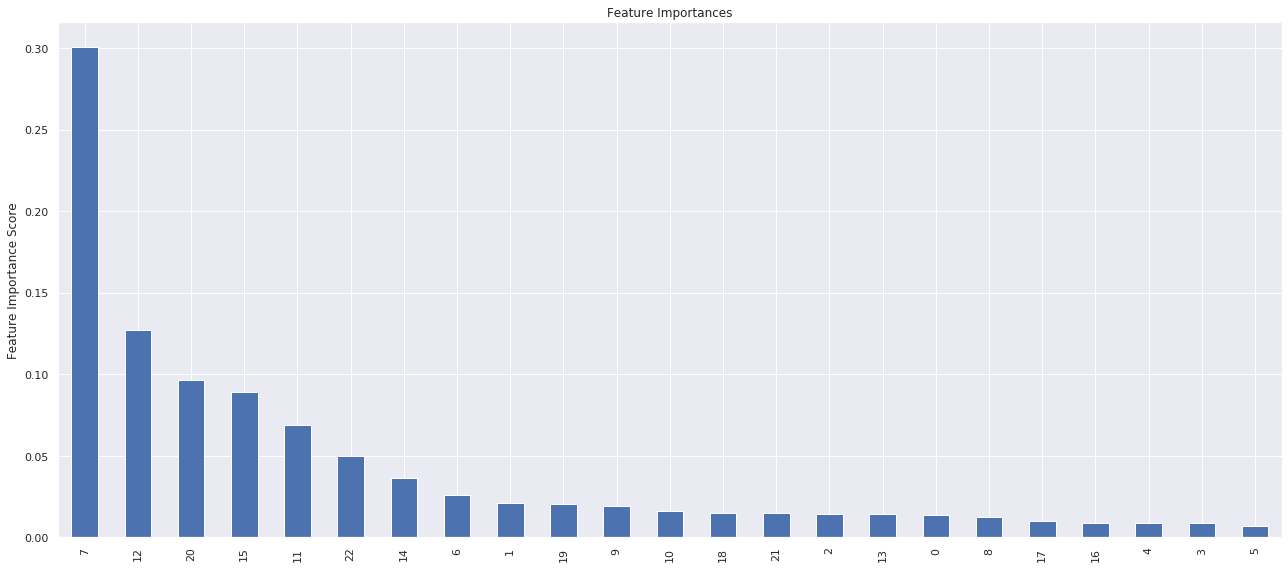

In [25]:
%%time

# Criando o modelo XGB com todas as otimizações
modeloXGB_v2 = XGBClassifier(learning_rate = 0.03, 
                             n_estimators = 2000, 
                             max_depth = grid_1.best_params_['max_depth'],
                             min_child_weight = grid_1.best_params_['min_child_weight'], 
                             gamma = grid_2.best_params_['gamma'], 
                             subsample = grid_3.best_params_['subsample'], 
                             colsample_bytree = grid_3.best_params_['colsample_bytree'],
                             reg_alpha = grid_4.best_params_['reg_alpha'],
                             objective = 'binary:logistic', 
                             n_jobs = -1,
                             scale_pos_weight = 1, 
                             seed = 123)

run_model(modeloXGB_v2, train_x, train_y)

# 0.05  e 1000            = 0.469435
# 0.01  e 2000            = 0.470060
# 0.03  e 2000 e seed=123 = 0.469158

In [26]:
# Visualizando o modelo XGBoost Otimizado
print(modeloXGB_v2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.1,
              learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=987, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=0.7, verbosity=1)


## 5. Submissions

In [31]:
# Preparando os dados de teste
new_test = test.drop(['ID'], axis=1).values
test_filtered = feat_selector.transform(new_test)
test_filtered = scaler.fit_transform(test_filtered)
test_filtered.shape

(114393, 23)

In [32]:
submission = pd.read_csv('../dataset/sample_submission.csv')
submission['PredictedProb'] = modeloXGB_v2.predict_proba(test_filtered)[:,1]
print(submission.shape)
submission.head()

(114393, 2)


,ID,PredictedProb
0,0,0.609258
1,1,0.847443
2,2,0.608554
3,7,0.655616
4,10,0.713626


In [35]:
submission.to_csv('../submission/submission_xgb_v.1.0.2.csv', index=False)

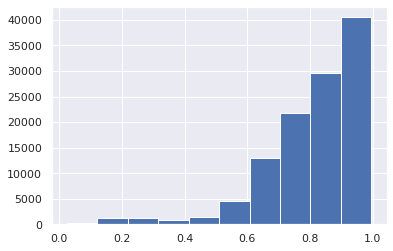

In [34]:
plt.hist(submission.PredictedProb)
plt.show()